# Preface

In this notebook, we
  * Investigate the effects of gradient descent and stochastic gradient descent on training NNs
  * Apply CNNs for basic image recognition tasks

This also serves to introduce the basics of the `keras` library with `tensorflow` backend. 

Install this library with
```
$pip install tensorflow
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
np.random.seed(123)  # For reproducibility

# Fashion MNIST Dataset

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset serves as one of the most basic benchmarks for image recognition. It is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Thus, it is almost exactly like the MNIST dataset for digit recognition, but generally harder. 

![Fashion MNIST](https://markusthill.github.io/images/2017-10-12-zalandos-fashion-mnist-dataset/zalando10x10.jpeg)

We can load the fashion MNIST data directly using `keras` as follows. We will need some simple preprocessing.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [8]:
x_train = x_train[:, :, :, np.newaxis] / 255.0  # Add channel dimension and normalize to [0, 1]
x_test = x_test[:, :, :, np.newaxis] / 255.0  # Add channel dimension and normalize to [0, 1]
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)  # convert to one-hot
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

We will also keep an array of labels in words for plotting purposes.

In [11]:
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}
labels_train = np.asarray([label_dict[u.argmax(0)] for u in y_train])
labels_test = np.asarray([label_dict[u.argmax(0)] for u in y_test])

Let us look at some example images

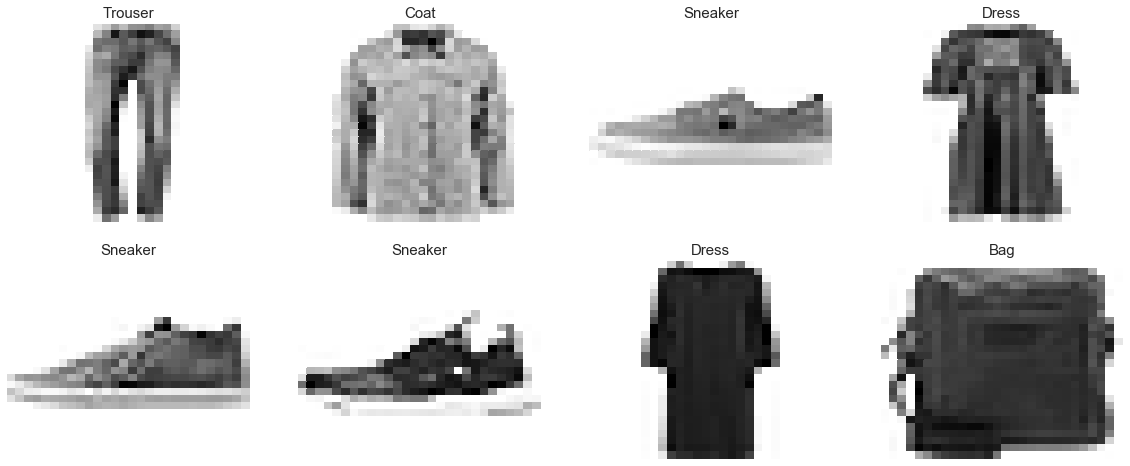

In [12]:
def plot_images(x, labels=None, nrow=2, ncol=4, im_type='image'):
    if im_type == 'filter':
        x = x.transpose(3, 0, 1, 2)  # Transpose to image type
    fig, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    num_samples = x.shape[0]
    num_channels = x.shape[-1]
    for a in ax.ravel():
        j = np.random.choice(num_samples)
        k = np.random.choice(num_channels)
        sns.heatmap(x[j, :, :, k], ax=a, cbar=False, cmap='gray_r')
        if labels is not None:
            a.set_title(labels[j])
        a.set_xticks([])
        a.set_yticks([])

plot_images(x_train, labels=labels_train)

# Fully Connected Neural Networks for Image Classification

Here we will introduce the simplest functionalities of `keras`. We will mostly use the [functional API](https://keras.io/getting-started/functional-api-guide/) since it is quite flexible and gets the job done for most basic use-cases. For more complex use-cases, one will often need to do [model-subclassing](https://keras.io/models/about-keras-models/). 

In [13]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

In a sense, the lowest level of abstraction in Keras is *layers*. We build a network consisting of layer objects. Model is a child of the Layer class that has additional functionalities. 

In [14]:
x = Input(shape=(28, 28, 1))
x_flat = Flatten()(x)
x_1 = Dense(units=32, activation='relu')(x_flat)
x_2 = Dense(units=10, activation='softmax')(x_1)
shallow_nn = Model(inputs=x, outputs=x_2)

We can also print a summary of the network, which is useful. Alternatively, you can use `keras.utils.plot_model` to visualize, but this requires installing the [`graphviz`](https://graphviz.gitlab.io/about/) package. For simplicity, we will not do that here. If you are interested, feel free to explore!

In [15]:
shallow_nn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


Next, we need to specify the loss functions and the optimizer we want to use. Finally, we want to monitor the *accuracy* metric. This can all be done in the `compile` method of `Model`. 

We will use the *cross-entropy loss* with the *SGD* optimizer. We will monitor the *accuracy*, in addition to the loss values. Do check out other choices as well and play around with them!
  * [Other losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
  * [Other optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/)
  * [Other metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/)

In [16]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD

In [17]:
shallow_nn.compile(
    loss=categorical_crossentropy,
    optimizer=SGD(0.01),
    metrics=['accuracy'],
)

In [18]:
initial_weights = shallow_nn.get_weights()  # We save initial weights for later use

We are now ready to train our model. Simply call the `train` method, while specifying suitable arguments.

In [19]:
history = shallow_nn.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=10,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/10
469/469 - 0s - loss: 1.1728 - accuracy: 0.6489 - val_loss: 0.8206 - val_accuracy: 0.7307
Epoch 2/10
469/469 - 0s - loss: 0.7206 - accuracy: 0.7667 - val_loss: 0.6779 - val_accuracy: 0.7707
Epoch 3/10
469/469 - 0s - loss: 0.6262 - accuracy: 0.7942 - val_loss: 0.6174 - val_accuracy: 0.7890
Epoch 4/10
469/469 - 0s - loss: 0.5779 - accuracy: 0.8077 - val_loss: 0.5875 - val_accuracy: 0.7960
Epoch 5/10
469/469 - 0s - loss: 0.5470 - accuracy: 0.8171 - val_loss: 0.5583 - val_accuracy: 0.8099
Epoch 6/10
469/469 - 0s - loss: 0.5247 - accuracy: 0.8233 - val_loss: 0.5418 - val_accuracy: 0.8131
Epoch 7/10
469/469 - 0s - loss: 0.5082 - accuracy: 0.8279 - val_loss: 0.5268 - val_accuracy: 0.8190
Epoch 8/10
469/469 - 0s - loss: 0.4947 - accuracy: 0.8320 - val_loss: 0.5133 - val_accuracy: 0.8243
Epoch 9/10
469/469 - 0s - loss: 0.4835 - accuracy: 0.8349 - val_loss: 0.5040 - val_accuracy: 0.8254
Epoch 10/10
469/469 - 0s - loss: 0.4738 - accuracy: 0.8385 - val_loss: 0.4977 - val_accuracy: 0.8272

The history object can be converted into a dataframe for easy analysis and plotting

In [20]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.172806,0.648850,0.820584,0.7307,0
1,0.720602,0.766733,0.677882,0.7707,1
2,0.626198,0.794183,0.617393,0.7890,2
3,0.577867,0.807667,0.587546,0.7960,3
4,0.546996,0.817117,0.558314,0.8099,4


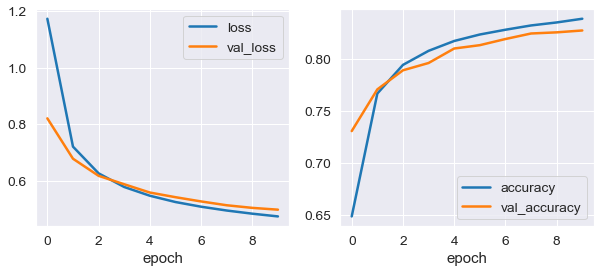

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[0])
history_df.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1])

## The Effect of Learning Rate on SGD

Let us now investigate the effect of varying learning rate on SGD performance. We will write a simple wrapper to clean up the evaluation code. 

In [24]:
class ParamEvaluator(object):
    def __init__(self,
                 model,
                 compile_default,
                 fit_default,
                 initial_weights=None):
        self.model = model
        self.compile_default = compile_default
        self.fit_default = fit_default
        self.initial_weights = initial_weights or model.get_weights()

    def reset_model(self):
        self.model.set_weights(self.initial_weights)

    def evaluate(self, **overrides):
        # reset model
        self.reset_model()
        
        # override and compile
        compile_overrides = {
            k: v
            for k, v in overrides.items() if k in self.compile_default.keys()
        }
        compile_updated = {**self.compile_default, **compile_overrides}
        self.model.compile(**compile_updated)

        # override and fit
        fit_overrides = {
            k: v
            for k, v in overrides.items() if k in self.fit_default.keys()
        }
        fit_updated = {**self.fit_default, **fit_overrides}
        history = self.model.fit(**fit_updated)
        history_df = pd.DataFrame(history.history)
        history_df['epoch'] = history.epoch
        return history_df

For fast evaluation for presentation purposes, we are going to reduce the size of the training set by 10 times. You are encouraged to try out the full version at home!

In [25]:
evaluator = ParamEvaluator(
    model=shallow_nn,
    initial_weights=initial_weights,
    compile_default={
        'loss': categorical_crossentropy,
        'optimizer': SGD(learning_rate=0.01),
        'metrics': ['accuracy'],
    },
    fit_default={
        'x': x_train[:6000],  # reduce training set
        'y': y_train[:6000],  # reduce training set
        'batch_size': 128,
        'epochs': 10,
        'validation_data': (x_test, y_test),
        'verbose': 0  # silences output    
    }
)

Let us now investigate the effect of varying learning rates

In [26]:
results_1 = evaluator.evaluate(optimizer=SGD(1.0))
results_05 = evaluator.evaluate(optimizer=SGD(0.5))
results_001 = evaluator.evaluate(optimizer=SGD(0.01))

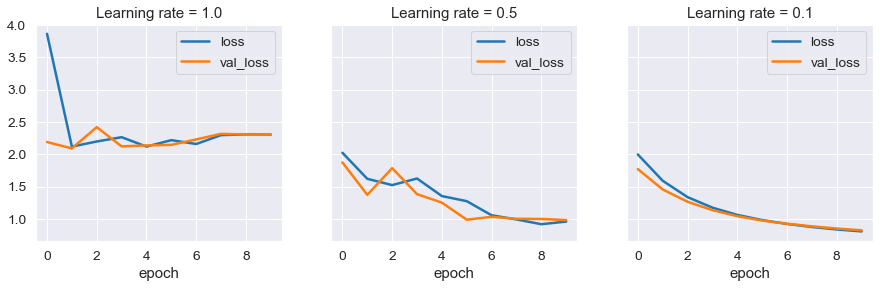

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

results_1.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[0], title='Learning rate = 1.0')
results_05.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[1], title='Learning rate = 0.5')
results_001.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[2], title='Learning rate = 0.1')

## The Effect of Batch Size on SGD

For fair comparison in terms of training/testing loss, if we increase the batch size we should increase the number of epochs in the same proportions. This ensures that the number of SGD runs is constant for each case.

**Remark.** For GPU training, the wall-clock does not scale linearly in batch size! Try it out if you have access to a GPU. 

In [28]:
results_16 = evaluator.evaluate(optimizer=SGD(0.05), batch_size=16, epochs=8)
results_32 = evaluator.evaluate(optimizer=SGD(0.05), batch_size=32, epochs=16)
results_128 = evaluator.evaluate(optimizer=SGD(0.05), batch_size=128, epochs=64)

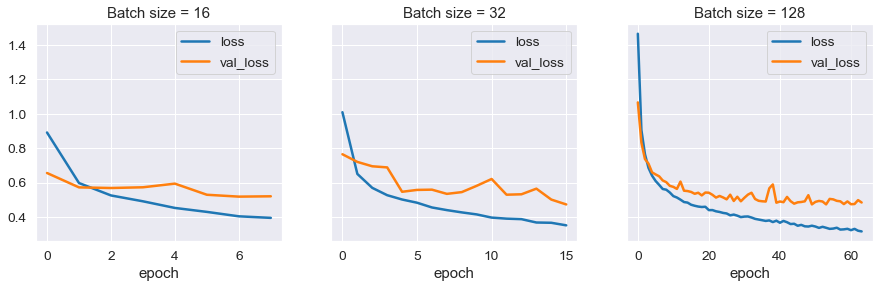

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

results_16.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[0], title='Batch size = 16')
results_32.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[1], title='Batch size = 32')
results_128.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[2], title='Batch size = 128')

# Shallow vs Deep Neural Networks

Now, let us investigate the effect of depth on the performance of neural networks. We will return to the full training set since we want to compare true accuracies.

## Shallow Baseline

First, let us get a baseline with our shallow_nn. We will train for 20 Epochs, using some sensible parameters we have found before. 

In [30]:
results_shallow = evaluator.evaluate(
    optimizer=SGD(0.01),
    batch_size=64,
    epochs=30,
    verbose=2,  # let us output some training details so that we have something to watch
    x=x_train,  # We use the full set again
    y=y_train,
)

Epoch 1/30
938/938 - 1s - loss: 0.9475 - accuracy: 0.7074 - val_loss: 0.6804 - val_accuracy: 0.7697
Epoch 2/30
938/938 - 1s - loss: 0.6049 - accuracy: 0.7990 - val_loss: 0.5813 - val_accuracy: 0.8007
Epoch 3/30
938/938 - 1s - loss: 0.5388 - accuracy: 0.8173 - val_loss: 0.5528 - val_accuracy: 0.8091
Epoch 4/30
938/938 - 1s - loss: 0.5051 - accuracy: 0.8274 - val_loss: 0.5186 - val_accuracy: 0.8172
Epoch 5/30
938/938 - 1s - loss: 0.4827 - accuracy: 0.8347 - val_loss: 0.4997 - val_accuracy: 0.8265
Epoch 6/30
938/938 - 1s - loss: 0.4657 - accuracy: 0.8398 - val_loss: 0.4914 - val_accuracy: 0.8261
Epoch 7/30
938/938 - 1s - loss: 0.4529 - accuracy: 0.8432 - val_loss: 0.4963 - val_accuracy: 0.8252
Epoch 8/30
938/938 - 1s - loss: 0.4419 - accuracy: 0.8479 - val_loss: 0.4677 - val_accuracy: 0.8355
Epoch 9/30
938/938 - 1s - loss: 0.4334 - accuracy: 0.8499 - val_loss: 0.4697 - val_accuracy: 0.8342
Epoch 10/30
938/938 - 1s - loss: 0.4248 - accuracy: 0.8532 - val_loss: 0.4534 - val_accuracy: 0.8401

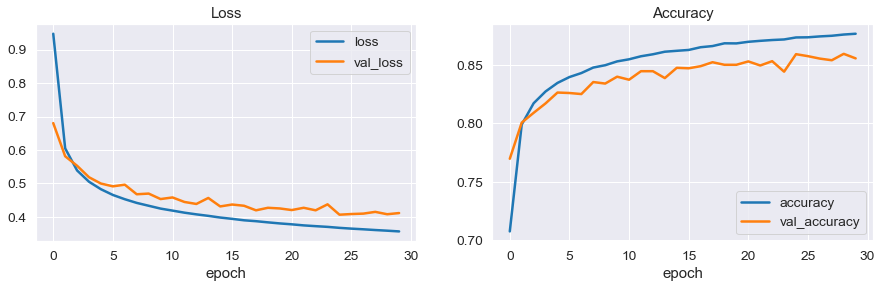

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
results_shallow.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[0], title='Loss')
results_shallow.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1], title='Accuracy')

Let's see what we have gotten wrong...

In [32]:
y_hat_test = shallow_nn.predict(x_test)
correct = y_hat_test.argmax(1) == y_test.argmax(1)
labels = [
    f'Correct: {c} \n True: {label_dict[y]} | Pred: {label_dict[yh]}'
    for c, y, yh in zip(correct, y_test.argmax(1), y_hat_test.argmax(1))
]

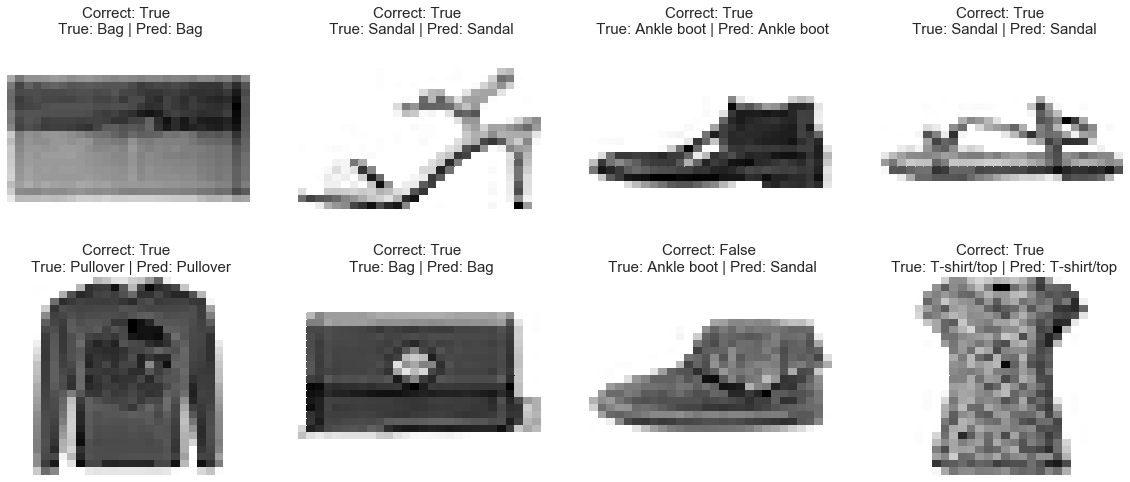

In [38]:
plot_images(x_test, labels=labels)

## Going Deeper

Let us now define a deeper network. Since we are not doing any repeated evaluations we just compile and train it as usual...

In [39]:
def build_deep_nn(layer_sizes):
    x = Input(shape=(28, 28, 1))
    h = Flatten()(x)
    for l in layer_sizes:
        h = Dense(units=l, activation='relu')(h)
    y = Dense(units=10, activation='softmax')(h)
    return Model(inputs=x, outputs=y)

In [40]:
deep_nn = build_deep_nn(layer_sizes=[512, 256, 128])

In [41]:
deep_nn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
________________________________________________

In [42]:
deep_nn.compile(
    loss=categorical_crossentropy,
    optimizer=SGD(0.01),
    metrics=['accuracy'],
)

In [43]:
history = deep_nn.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=30,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/30
469/469 - 1s - loss: 1.0307 - accuracy: 0.6876 - val_loss: 0.6698 - val_accuracy: 0.7761
Epoch 2/30
469/469 - 1s - loss: 0.5925 - accuracy: 0.8033 - val_loss: 0.5617 - val_accuracy: 0.8054
Epoch 3/30
469/469 - 1s - loss: 0.5165 - accuracy: 0.8220 - val_loss: 0.5164 - val_accuracy: 0.8149
Epoch 4/30
469/469 - 1s - loss: 0.4795 - accuracy: 0.8325 - val_loss: 0.4871 - val_accuracy: 0.8276
Epoch 5/30
469/469 - 1s - loss: 0.4543 - accuracy: 0.8401 - val_loss: 0.4789 - val_accuracy: 0.8321
Epoch 6/30
469/469 - 1s - loss: 0.4382 - accuracy: 0.8460 - val_loss: 0.4625 - val_accuracy: 0.8367
Epoch 7/30
469/469 - 1s - loss: 0.4222 - accuracy: 0.8516 - val_loss: 0.4471 - val_accuracy: 0.8399
Epoch 8/30
469/469 - 1s - loss: 0.4132 - accuracy: 0.8556 - val_loss: 0.4321 - val_accuracy: 0.8458
Epoch 9/30
469/469 - 1s - loss: 0.4004 - accuracy: 0.8597 - val_loss: 0.4251 - val_accuracy: 0.8503
Epoch 10/30
469/469 - 1s - loss: 0.3929 - accuracy: 0.8616 - val_loss: 0.4230 - val_accuracy: 0.8493

In [44]:
results_deep = pd.DataFrame(history.history)
results_deep['epoch'] = history.epoch

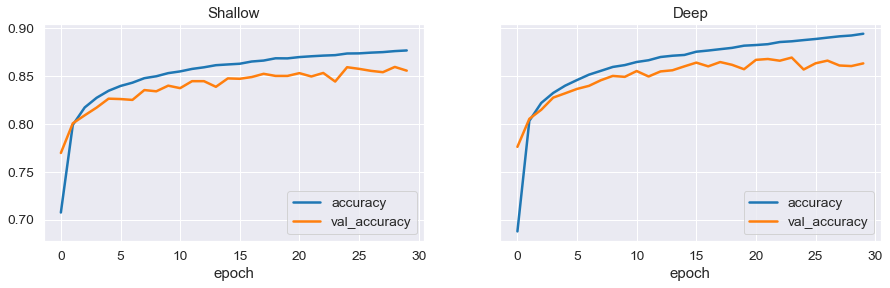

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
results_shallow.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[0], title='Shallow')
results_deep.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1], title='Deep')

**Exercise.** Try to go deeper and wider, does that help?

# The Effect of Permutation on Fully Connected Networks

We have discussed in class that permutation does not affect fully connected networks. Let us confirm this here.

In [46]:
def permute_pixels(*images):
    img_size = images[0].shape[1:-1]
    idx = np.random.permutation(img_size[0])
    idy = np.random.permutation(img_size[1])
    images_permuted = []
    for img in images:
        img_perm = img[:, idx, :, :]
        img_perm = img_perm[:, :, idy, :]
        images_permuted.append(img_perm)
    return images_permuted

In [47]:
x_train_perm, x_test_perm = permute_pixels(x_train, x_test)

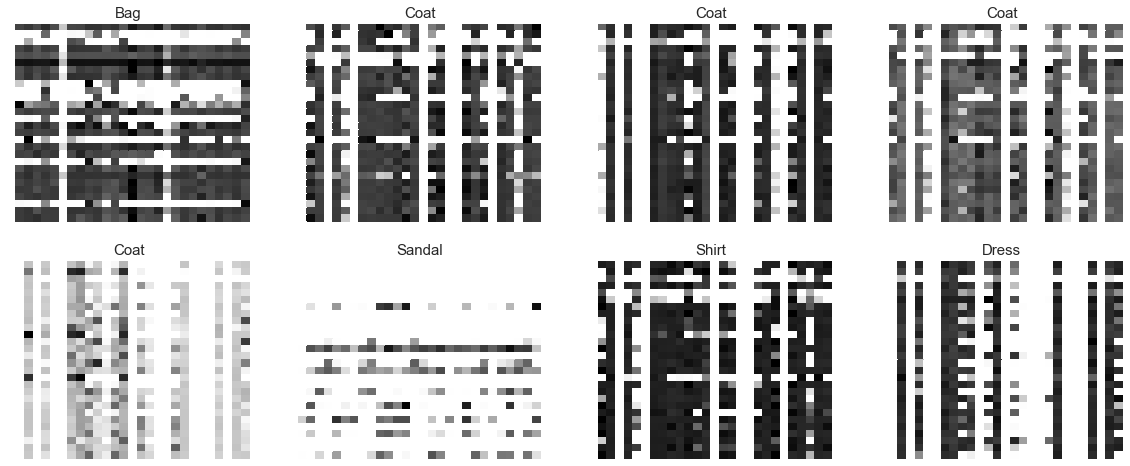

In [48]:
plot_images(x_train_perm, labels_train)

Clearly, humans have no way of telling these apart. Let us see how our shallow NN works on this dataset.

In [49]:
results_perm = evaluator.evaluate(
    optimizer=SGD(0.01),
    batch_size=64,
    epochs=30,
    verbose=2,
    x=x_train_perm,
    y=y_train,
    validation_data=(x_test_perm, y_test),
)

Epoch 1/30
938/938 - 1s - loss: 1.0234 - accuracy: 0.6730 - val_loss: 0.7106 - val_accuracy: 0.7601
Epoch 2/30
938/938 - 1s - loss: 0.6195 - accuracy: 0.7943 - val_loss: 0.5986 - val_accuracy: 0.7918
Epoch 3/30
938/938 - 1s - loss: 0.5453 - accuracy: 0.8160 - val_loss: 0.5565 - val_accuracy: 0.8058
Epoch 4/30
938/938 - 1s - loss: 0.5084 - accuracy: 0.8266 - val_loss: 0.5328 - val_accuracy: 0.8140
Epoch 5/30
938/938 - 1s - loss: 0.4849 - accuracy: 0.8337 - val_loss: 0.5078 - val_accuracy: 0.8232
Epoch 6/30
938/938 - 1s - loss: 0.4678 - accuracy: 0.8389 - val_loss: 0.4938 - val_accuracy: 0.8258
Epoch 7/30
938/938 - 1s - loss: 0.4552 - accuracy: 0.8436 - val_loss: 0.4924 - val_accuracy: 0.8232
Epoch 8/30
938/938 - 1s - loss: 0.4447 - accuracy: 0.8457 - val_loss: 0.4703 - val_accuracy: 0.8337
Epoch 9/30
938/938 - 1s - loss: 0.4357 - accuracy: 0.8495 - val_loss: 0.4617 - val_accuracy: 0.8347
Epoch 10/30
938/938 - 1s - loss: 0.4287 - accuracy: 0.8514 - val_loss: 0.4621 - val_accuracy: 0.8343

Let us now compare the results with the shallow NN baseline with un-permuted data.

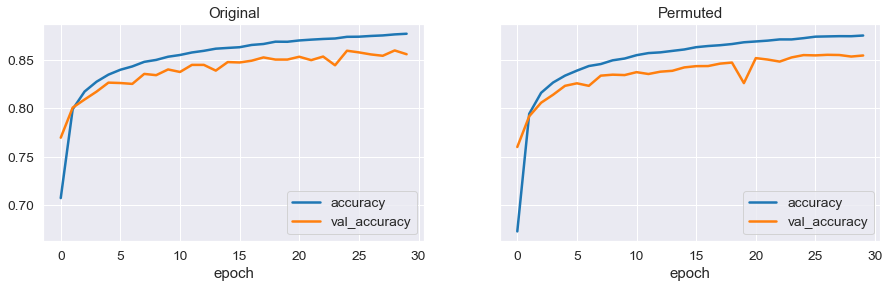

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
results_shallow.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[0], title='Original')
results_perm.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1], title='Permuted')

They are almost indistinguisable! This highlights that the fully connected NN, while being a sufficiently accurate model, is not at all doing what humans are doing when we recognize these images!

# Convolutional Neural Networks on Fashion MNIST

Let us now test the performance of convolutional neural networks (CNNs) on the performance on Fashion MNIST.

In [51]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

In [52]:
x = Input(shape=(28, 28, 1))

In [61]:
# Convolution + pool 1
h1 = Conv2D(filters=6, kernel_size=3, activation='relu', padding='same')(x)

In [62]:
h1 = MaxPool2D(strides=2)(h1)

In [64]:
# Convolution + pool 2
h2 = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(h1)
h2 = MaxPool2D(strides=2)(h2)

In [65]:
h2

<tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(None, 7, 7, 16) dtype=float32>

In [66]:
# Fully connected
h2_flattened = Flatten()(h2)

In [68]:
h3 = Dense(units=120, activation='relu')(h2_flattened)
h4 = Dense(units=84, activation='relu')(h3)
h5 = Dense(units=10, activation='softmax')(h4)

cnn = Model(inputs=x, outputs=h5)

In [69]:
cnn.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)              

Let's train and evaluate the CNN using our `ParamEvaluator` class as before. (Uncomment to run)

In [70]:
# evaluator_cnn = ParamEvaluator(
#     model=cnn,
#     compile_default={
#         'loss': categorical_crossentropy,
#         'optimizer': SGD(learning_rate=0.1),
#         'metrics': ['accuracy'],
#     },
#     fit_default={
#         'x': x_train,
#         'y': y_train,
#         'batch_size': 128,
#         'epochs': 30,
#         'validation_data': (x_test, y_test),
#         'verbose': 2,
#     }
# )

# Train
# results_cnn = evaluator_cnn.evaluate()
# cnn.save('cnn.h5')

In [71]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
# results_deep.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[0], title='Deep FCNN')
# results_cnn.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1], title='CNN')

We can skip the training before if we have a saved model, which we can just load

In [72]:
from sklearn.metrics import accuracy_score

In [73]:
cnn = tf.keras.models.load_model('cnn.h5')

In [74]:
y_hat_train_cnn = cnn.predict(x_train)
y_hat_test_cnn = cnn.predict(x_test)
y_hat_train_fcnn = deep_nn.predict(x_train)
y_hat_test_fcnn = deep_nn.predict(x_test)

print(f'FCNN train accuracy: {accuracy_score(y_train.argmax(1), y_hat_train_fcnn.argmax(1))}')
print(f'FCNN test accuracy: {accuracy_score(y_test.argmax(1), y_hat_test_fcnn.argmax(1))}')

print(f'CNN train accuracy: {accuracy_score(y_train.argmax(1), y_hat_train_cnn.argmax(1))}')
print(f'CNN test accuracy: {accuracy_score(y_test.argmax(1), y_hat_test_cnn.argmax(1))}')

FCNN train accuracy: 0.8876833333333334
FCNN test accuracy: 0.8634
CNN train accuracy: 0.96265
CNN test accuracy: 0.9045


There are many things you can do to improve the above, including by not limited to
  * Tweak network sizes/depth and overall architecture
  * Use other optimizers (e.g. try Adam!)
  * Data augmentation (see [keras functionalities](https://keras.io/preprocessing/image/))

## Exploring the Trained Network

Let us first look at the features that are extracted in our convolution layers. We use a trick by defining a new `keras` model that has these feature maps as outputs, so we can easily call the `predict` method to get the results.

In [75]:
cnn_feature_maps = Model(inputs=x, outputs=[h1, h2])

In [76]:
h1_val, h2_val = cnn_feature_maps.predict(x_test)

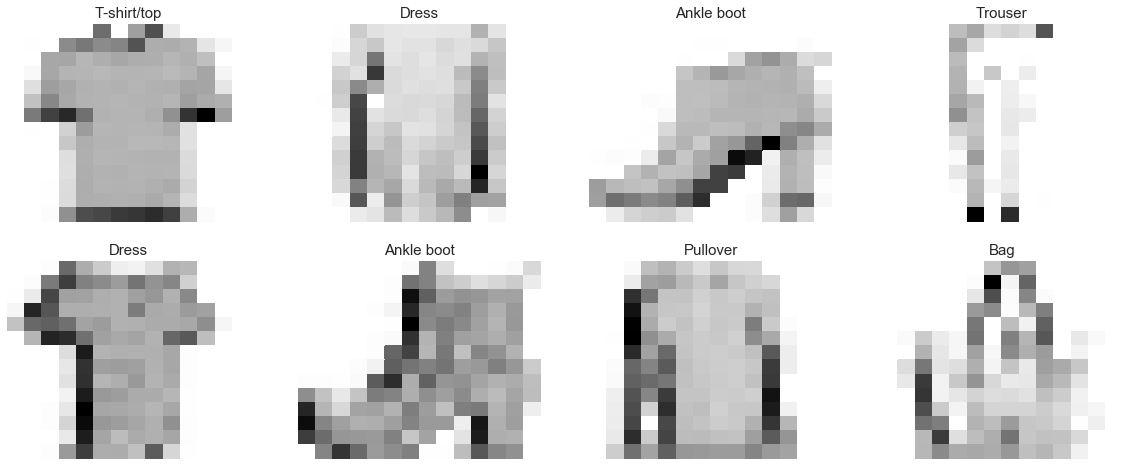

In [77]:
plot_images(h1_val, labels=labels_test)

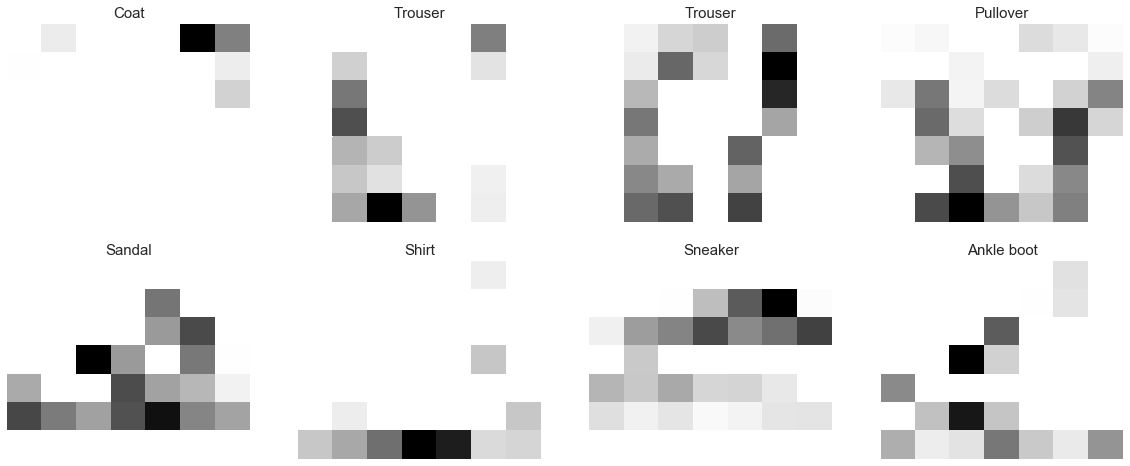

In [78]:
plot_images(h2_val, labels=labels_test)